In [1]:
from momentfm.data.anomaly_detection_dataset import AnomalyDetectionDataset

test_dataset = AnomalyDetectionDataset(data_split='test', random_seed=13)

/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


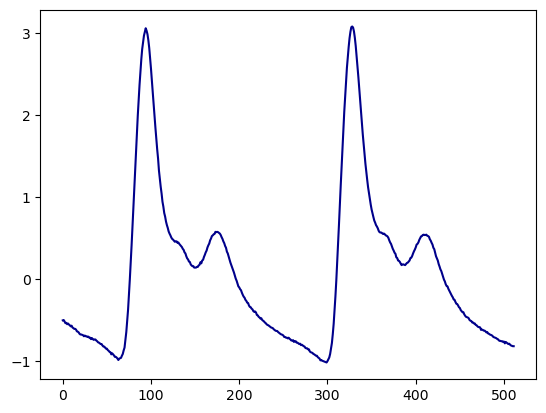

In [2]:
import numpy as np
import matplotlib.pyplot as plt

idx = np.random.randint(0, len(test_dataset))
plt.plot(test_dataset[idx][0].squeeze(), c='darkblue')
plt.show()

In [3]:
from torch.utils.data import DataLoader

test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=False)

In [ ]:
from dvats import utils as ut

In [ ]:
timer = ut.Time()
timer.start()

In [4]:
from momentfm import MOMENTPipeline

model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large", 
    model_kwargs={"task_name": "reconstruction"},  # For anomaly detection, we will load MOMENT in `reconstruction` mode
    # local_files_only=True,  # Whether or not to only look at local files (i.e., do not try to download the model).
)

config.json:   0%|          | 0.00/951 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

In [ ]:
timer.end()
timer.duration

In [5]:
import torch
from tqdm import tqdm

model = model.to("cuda").float()

trues, preds, labels = [], [], []
with torch.no_grad():
    for batch_x, batch_masks, batch_labels in tqdm(test_dataloader, total=len(test_dataloader)):
        batch_x = batch_x.to("cuda").float()
        batch_masks = batch_masks.to("cuda")

        output = model(batch_x, input_mask=batch_masks) # [batch_size, n_channels, window_size]

        trues.append(batch_x.detach().squeeze().cpu().numpy())
        preds.append(output.reconstruction.detach().squeeze().cpu().numpy())
        labels.append(batch_labels.detach().cpu().numpy())

  0% 0/3 [00:00<?, ?it/s]/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100% 3/3 [00:05<00:00,  2.00s/it]


In [25]:
output.embeddings.shape

AttributeError: 'NoneType' object has no attribute 'shape'

In [24]:
? output.embeddings

Type:        NoneType
String form: None
Docstring:   <no docstring>

In [6]:
import numpy as np

trues = np.concatenate(trues, axis=0).flatten()
preds = np.concatenate(preds, axis=0).flatten()
labels = np.concatenate(labels, axis=0).flatten()

# The last and the second to last windows have overlapping timesteps. We will remove these overlapping predictions
n_unique_timesteps = 512 - trues.shape[0] + test_dataset.length_timeseries
trues = np.concatenate([trues[:512*(test_dataset.length_timeseries//512)], trues[-n_unique_timesteps:]])
preds = np.concatenate([preds[:512*(test_dataset.length_timeseries//512)], preds[-n_unique_timesteps:]])
labels = np.concatenate([labels[:512*(test_dataset.length_timeseries//512)], labels[-n_unique_timesteps:]])
assert trues.shape[0] == test_dataset.length_timeseries

# We will use the Mean Squared Error (MSE) between the observed values and MOMENT's predictions as the anomaly score
anomaly_scores = (trues - preds)**2

In [7]:
from momentfm.utils.anomaly_detection_metrics import adjbestf1

print(f"Zero-shot Adjusted Best F1 Score: {adjbestf1(y_true=labels, y_scores=anomaly_scores)}") 

Zero-shot Adjusted Best F1 Score: 0.9769317149626442


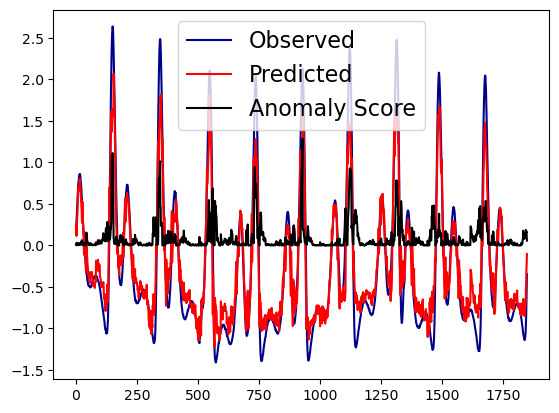

In [8]:
anomaly_start = 74158
anomaly_end = 74984
start = anomaly_start-512
end = anomaly_end+512

plt.plot(trues[start:end], label="Observed", c='darkblue')
plt.plot(preds[start:end], label="Predicted", c='red')
plt.plot(anomaly_scores[start:end], label="Anomaly Score", c='black')
plt.legend(fontsize=16)
plt.show()

In [9]:
test_dataloader.dataset

In [10]:
test_dataloader.dataset[0][0].shape
len (test_dataloader.dataset[0])

3

In [11]:
len(test_dataloader.dataset)

154

In [12]:
#dataset = np.array(test_dataloader.dataset)

In [13]:
#dataset.shape

In [14]:
inputs = []
for i in range (len(test_dataloader.dataset)):
    inputs.append(test_dataloader.dataset[i][0])

In [15]:
enc_input = torch.from_numpy(np.array(inputs))

In [16]:
enc_input.shape

torch.Size([154, 1, 512])

In [20]:
model.DataEmbedding

AttributeError: 'MOMENTPipeline' object has no attribute 'DataEmbedding'

In [17]:
embs = get_enc_embs(
    X          = test_dataloader.dataset, 
    enc_learn  = model, 
    cpu        = 'False', 
    to_numpy   = True,
    batch_size = enc_run.config['batch_size'],
    verbose    = 1
)

NameError: name 'get_enc_embs' is not defined